# Unet Satcen Finetuning

Fine tune the Unet model trained on the Airbus dataset using the Satcen dataset.

## Construct the Training Dataset

Load and split the Satcen dataset into train and test sets.

- train: 50% 
- validation: 25%
- test: 25%

In [18]:
import os
import pathlib
from PIL import Image, ImageDraw as Drawer
import matplotlib.pyplot as plt
import numpy as np
import ijson
import json
from sklearn.model_selection import train_test_split
import shutil
from fastai.vision.all import *
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

# path to satcen dataset
satcen_path = pathlib.Path('../satcen_dataset/original').resolve()

# path to full satcen dataset
satcen_path_full = pathlib.Path('../satcen_dataset/full').resolve()

In [2]:
# load the Satcen image filenames
satcen = [f for f in os.listdir(satcen_path/'pictures')]
print('Total number of Satcen images:', len(satcen))

# load the json file containing bounding boxes
satcen_json = [entry for entry in ijson.items(open(satcen_path/'SatCen_skiffs256.json'), 'batch.annotations.item')]

# pre-process the json
# resulting format should be
# {name: ..., boundind_boxes: [[{'x': ..., 'y': ...}, ...], ...]}
satcen_json = list(map(lambda x: {'name': x['name'], 'bounding_boxes': [e['data'] for e in x['objects']]}, satcen_json))

# keep only annotated images
satcen = list(map(lambda x: x['name'], satcen_json))
print('Number of annotated images:', len(satcen))

Total number of Satcen images: 2170
Number of annotated images: 1833


### Generate Ground Truth Labels

Compute ground truth for images in the Satcen dataset based on the given bounding boxes.
Ground truth labels should be saved as *.png* files in the *satcen_dataset/labeled_images_binary* folder. Files should have _L at the end of the filename.

In each ground truth image:
- 0 pixel value represents background pixel
- 1 pixel value represents ship pixel

In [3]:
# compute segmentation mask of a Satcen image based on its bounding box
# @param img_name - filename of the image for which to compute ground truth
# @param bounding_boxes - list of bounding boxes for that image
# @param save - whether or not to save the mask
# @param path - where to save the mask
# @return mask - PIL image representing the mask of the given image
def get_image_mask_satcen(img_name, bounding_boxes, path, save = False):
    
    # create the skeleton of the segmentation mask
    # size is constant for satcen dataset, 256 x 256
    mask = Image.fromarray(np.zeros((256, 256)))

    # get a drawer object
    draw = Drawer.Draw(mask)

    # loop through the bounding boxes
    for bb in bounding_boxes:

        # convert coordinates to required format
        coords = [(c['x'], c['y']) for c in bb]

        # draw the bounding box on the image
        draw.polygon(coords, fill=1)

    if save:
        mask.convert('RGB').save(path/f'{img_name[:-4]}_L.png')

    return mask

# function that generates and saves masks for Satcen images
# @param path - where to save the masks
def save_all_satcen_masks(path):

    # delete all the files in the target directory
    for f in os.listdir(path):
        os.remove(path/f)

    # loop through all satcen images
    for img in satcen:

        # get the corresponding list of bounding boxes
        json_entry = [e for e in satcen_json if e['name'] == img]
        bounding_boxes = json_entry[0]['bounding_boxes'] if len(json_entry) > 0 else []

        # generate and save mask
        get_image_mask_satcen(img, bounding_boxes, path, save=True)

# save_all_satcen_masks(satcen_path/'labeled_images_binary')

### Split Dataset

Split the entire Satcen dataset into training (70%) and testing (30%) datasets. Save the training and validation data in the *satcen_dataset/train_pictures* folder.

In [4]:
# construct the ground truth labels array
y = []
positives = 0
negatives = 0

# loop through all Satcen images
for filename in satcen:
    mask_arr = np.array(Image.open(satcen_path/'labeled_images_binary'/f'{filename[:-4]}.png'))

    if np.any(mask_arr > 0): # positive observation
        y.append(1) 
        positives += 1
    else: # negative observation
        y.append(0)
        negatives += 1

print(f'Number of positive observations: {positives} ({positives / len(satcen) * 100}%)')
print(f'Number of negative observations: {negatives} ({negatives / len(satcen) * 100}%)')

# sanity check that image filenames and corresponding ground truth label 
# are in the correct order in the array
for i in range(len(satcen)):

    img = satcen[i]
    mask = np.array(Image.open(satcen_path/'labeled_images_binary'/f'{img[:-4]}.png'))

    if (np.any(mask > 0) and y[i] == 0) or (not np.any(mask > 0) and y[i] == 1):
        raise Exception('Labels do not correspond for ' + img)

Number of positive observations: 1525 (83.19694489907256%)
Number of negative observations: 308 (16.80305510092744%)


In [5]:
# # make the splits
# train_data, test_data = train_test_split(satcen, train_size=0.7, stratify=y)

# # check how many positive and negative observations are in each subset
# print('### Train Data ###')
# print('Size:', len(train_data))
# train_pos = len([f for f in train_data if y[satcen.index(f)] == 1])
# train_neg = len([f for f in train_data if y[satcen.index(f)] == 0])
# print(f'Positive observations: {train_pos} ({train_pos / len(train_data) * 100}%)')
# print(f'Negative observations: {train_neg} ({train_neg / len(train_data) * 100}%)', '\n')

# print('### Test Data ###')
# print('Size:', len(test_data))
# test_pos = len([f for f in test_data if y[satcen.index(f)] == 1])
# test_neg = len([f for f in test_data if y[satcen.index(f)] == 0])
# print(f'Positive observations: {test_pos} ({test_pos / len(test_data) * 100}%)')
# print(f'Negative observations: {test_neg} ({test_neg / len(test_data) * 100}%)', '\n')

# # remove all files currently in the train_valid folder
# for f in os.listdir(satcen_path/'train_pictures'):
#     os.remove(satcen_path/'train_pictures'/f)

# # save training data
# for f in train_data:
#     src = satcen_path/'pictures'/f
#     dst = satcen_path/'train_pictures'/f
#     shutil.copy(src, dst)

print('Total number of training examples:', len(os.listdir(satcen_path/'train_pictures')))

Total number of training examples: 1283


## Fine Tuning

### Construct the Model

Construct the model in the same way as the original one trained on the Airbus dataset. Load the weights of the Airbus model.

Save the model as *unet_satcen_finetuned.pth* in the *ship_detection/models* folder.

/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tudor/satcen-ship-detection/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


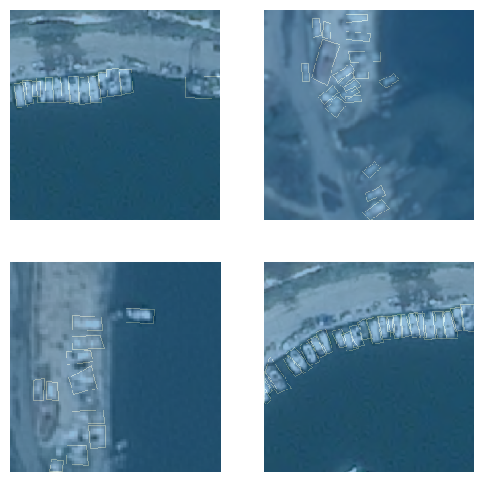

In [6]:
# define a function that gets the label for a given image
def label_func(fn): return satcen_path/'labeled_images_binary'/f'{fn.stem}.png'

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(satcen_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    item_tfms=Resize(224) # resize images to 224x224
)

# load the data in the datablock
dls = dblock.dataloaders(satcen_path/'train_pictures/', bs=4, device=torch.device('cuda'))

dls.show_batch(max_n=4)

# create the learner
unet = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

# load the model
unet.load('unet_googlenet')

### Train the Model

Train using the same approach as the original model, then save the model.

In [8]:
# # train the model
# unet.fine_tune(4, freeze_epochs=3)

# # save the model
# print('Saving model...')
# unet.save('unet_satcen_finetuned')
# print('Saved model')

## Testing

Test the fine-tuned model on the remainder of the Satcen dataset. 

### Construct the Test Set

In [9]:
satcen_test = list(set(satcen) - set(os.listdir(satcen_path/'train_pictures')))
y_test = np.array(y)[[satcen.index(e) for e in satcen_test]]

print('Size of test set:', len(satcen_test))

test_p = np.sum(y_test == 1)
test_n = np.sum(y_test == 0)

print(f'Positive test examples: {test_p} ({test_p / len(satcen_test)}%)')
print(f'Negative test examples: {test_n} ({test_n / len(satcen_test)}%)')

# # sanity check
# for i in range(len(satcen_test)):

#     img = satcen_test[i]
#     mask = np.array(Image.open(satcen_path/'labeled_images_binary'/f'{img[:-4]}_L.png'))

#     if (np.any(mask == 1) and y_test[i] == 0) or (not np.any(mask == 1) and y_test[i] == 1):
#         raise Exception('Labels do not correspond for ' + img)

Size of test set: 550
Positive test examples: 458 (0.8327272727272728%)
Negative test examples: 92 (0.16727272727272727%)


### Load the model

Load the fine-tuned U-net model.

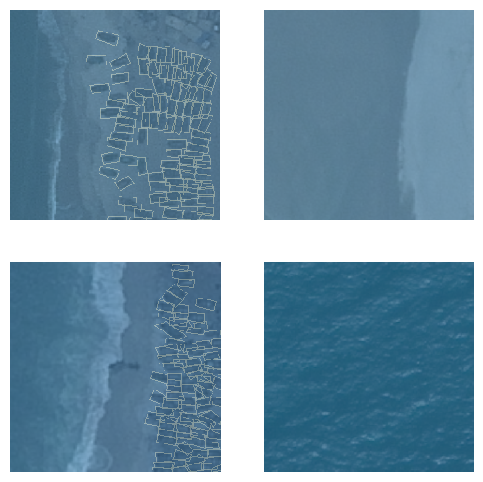

In [11]:
# define a function that gets the label for a given image
def label_func(fn): return satcen_path/'labeled_images_binary'/f'{fn.stem}.png'

# create a datablock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(np.loadtxt(satcen_path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    get_y=label_func,
    item_tfms=Resize(224) # resize images to 224x224
)

# load the data in the datablock
torch.cuda.init()
dls = dblock.dataloaders(satcen_path/'train_pictures/', bs=4, device=torch.device('cuda'))

dls.show_batch(max_n=4)

# create the learner
unet_finetuned = unet_learner(dls, googlenet,
    self_attention=True,
    loss_func=FocalLoss(),
    lr=1e-4
)

# load the model
unet_finetuned.load('unet_satcen_finetuned')

### Evaluate Model

Plot ROC and PR curves for the model.

For each test image, compute a decision score (*z* array) representing the maximum value in the raw U-net output. Compare the decision scores against the threshold to determine the type of prediction.

In [107]:
# compute and save decision scores
z = []
for img in satcen_test:

    # generate prediction
    with unet_finetuned.no_bar(), unet_finetuned.no_logging(): _, _, pred = unet_finetuned.predict(satcen_path/'pictures'/img)
    z.append(np.max(pred.numpy()[1]))
        

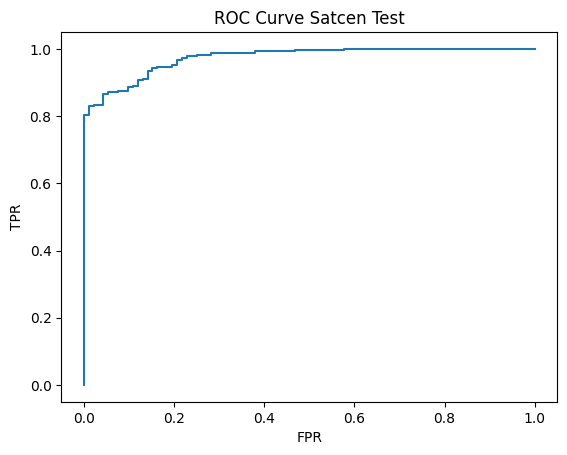

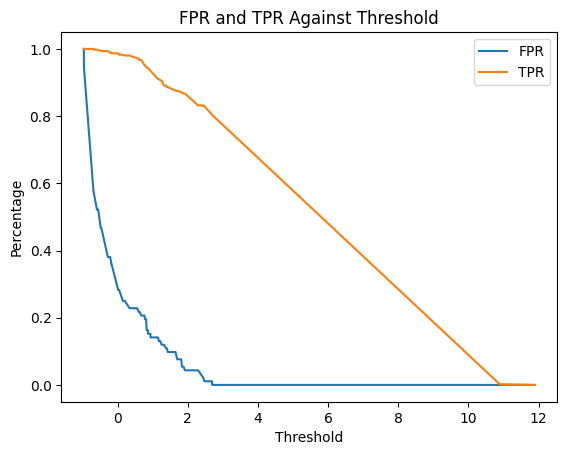

In [108]:
# ROC
fprs, tprs, thresholds = roc_curve(y_test, z)
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Satcen Test')
plt.show()

plt.plot(thresholds, fprs, thresholds, tprs)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.legend(['FPR', 'TPR'])
plt.title('FPR and TPR Against Threshold')
plt.show()

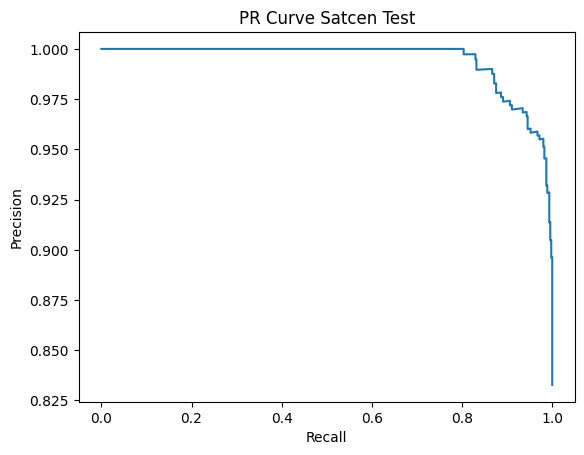

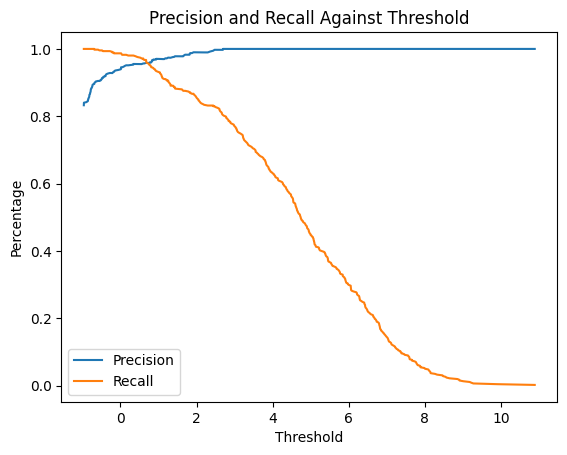

In [109]:
# PR
precisions, recalls, thresholds = precision_recall_curve(y_test, z)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve Satcen Test')
plt.show()

thresholds = np.append(thresholds, math.inf)
plt.plot(thresholds, precisions, thresholds, recalls)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Precision and Recall Against Threshold')
plt.legend(['Precision', 'Recall'])
plt.show()

## Testing on Full Dataset

Test the Unet model on the entire dataset, including the additional images.

Raw outputs of Unet should be saved as *.npy* files in the *satcen_dataset/full/results_unet* folder, with *_unet_out* after the original file name.

### Construct the Test Set

The test set represents the set difference between all images (*satcen_dataset/full/pictures*) and the images used for training (*satcen_dataset/original/train_pictures*). 

Make sure to **remove images that are not annotated**!

In [110]:
# get all images
all_images = os.listdir(satcen_path_full/'pictures')
print(f'Total number of images: {len(all_images)}')

# get training images
train_images = os.listdir(satcen_path/'train_pictures')
print(f'Number of training images: {len(train_images)}')

# construct the test set
test_images = list(set(all_images) - set(train_images))
print(f'Number of test images: {len(test_images)}')

Total number of images: 9420
Number of training images: 1283
Number of test images: 8137


### Construct the Test Labels

Use the *labels.json* file to construct a list representing the class labels of the images in the *test_images* list.

Labels:
- positive: 1
- negative: 0

In [111]:
# open the json
labels_file = open(satcen_path_full/'labels.json')
labels_json = json.load(labels_file)

# filter json to only contain entries for test images
labels_json = list(filter(lambda x: x['name'] in test_images, labels_json))

# map the json to list of binary labels
y = []
for img in test_images:

    bounding_boxes = list(filter(lambda x: x['name'] == img, labels_json))[0]['bounding_boxes']
    y.append(1 if len(bounding_boxes) > 0 else 0)

# print test set stats
y = np.array(y)
print('Test set stats')
print(f'Total number of test examples: {len(y)}')
print(f'Number of positive observations: {np.sum(y==1)}')
print(f'Number of negative observations: {np.sum(y==0)}')

Test set stats
Total number of test examples: 8137
Number of positive observations: 458
Number of negative observations: 7679


### Run Unet on Test Examples

Save the results in the *satcen_dataset/full/results_unet* folder as *.npy* files with *_unet_out* after the original filename.

In [112]:
# # remove all files in the results_unet folder
# for f in os.listdir(satcen_path_full/'results_unet'):
#     os.remove(satcen_path_full/'results_unet'/f)

# # loop through all images in the test set
# for test_img in test_images:

#     # generate prediction
#     with unet.no_bar(), unet.no_logging(): _, _, pred = unet.predict(satcen_path_full/'pictures'/test_img)
#     pred = pred.numpy()[1]

#     # save prediction as .npy
#     np.save(satcen_path_full/'results_unet/'f'{test_img[:-4]}_unet_out', pred)

print(f'Number of predictions: {len(os.listdir(satcen_path_full/"results_unet"))}')

Number of predictions: 8137


### Evaluate the Model

Evaluate the Unet model as a binary classifier on the **full Satcen dataset**.

Load raw outputs from the *satcen_dataset/full/results_unet* folder, generate decision scores from the raw outputs and plot the ROC and PR curves.

In [115]:
# decision scores
z = []

# loop through all the test images
for test_img in test_images:

    # load raw output of unet
    raw_unet_output = np.load(satcen_path_full/'results_unet'/f'{test_img[:-4]}_unet_out.npy')
    dec_score = np.max(raw_unet_output)

    # store decision score
    z.append(dec_score)

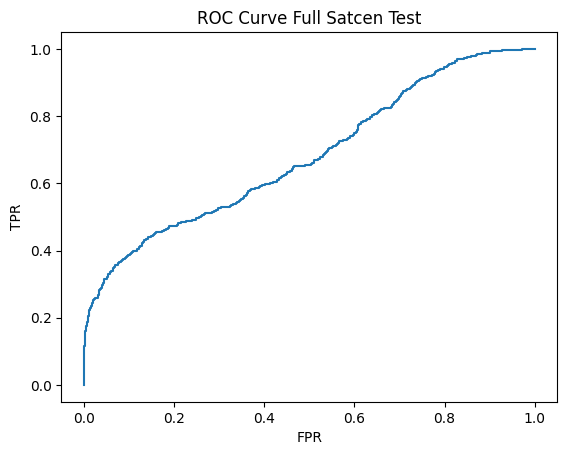

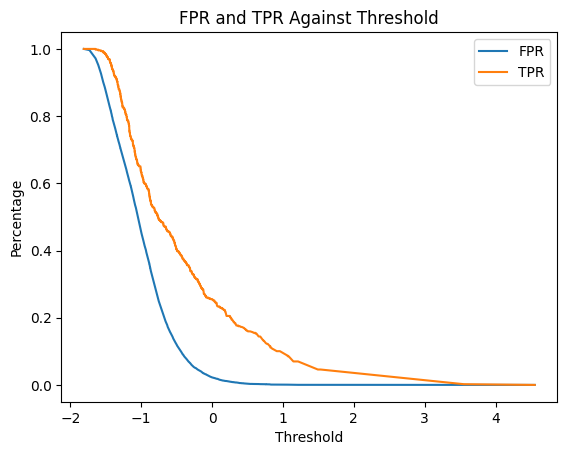

In [116]:
# ROC
fprs, tprs, thresholds = roc_curve(y, z)
plt.plot(fprs, tprs)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Full Satcen Test')
plt.show()

plt.plot(thresholds, fprs, thresholds, tprs)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.legend(['FPR', 'TPR'])
plt.title('FPR and TPR Against Threshold')
plt.show()

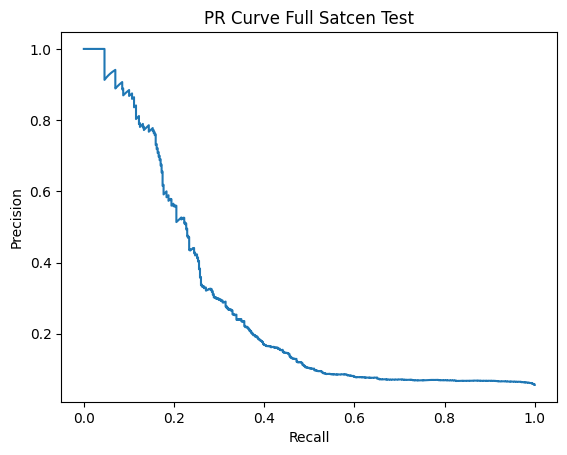

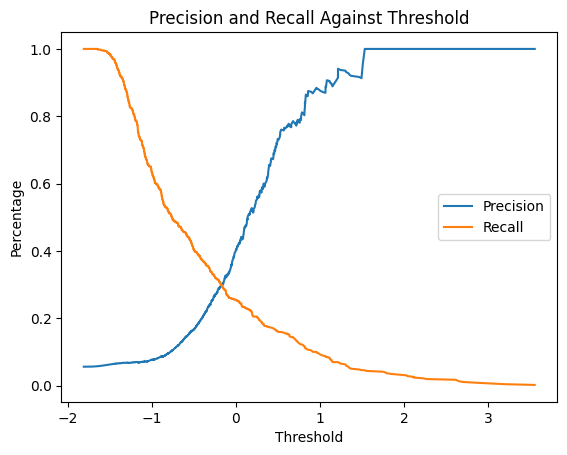

In [69]:
# PR
precisions, recalls, thresholds = precision_recall_curve(y, z)
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve Full Satcen Test')
plt.show()

thresholds = np.append(thresholds, math.inf)
plt.plot(thresholds, precisions, thresholds, recalls)
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Precision and Recall Against Threshold')
plt.legend(['Precision', 'Recall'])
plt.show()